In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import dill
import pandas as pd
import numpy as np
from sklearn import base
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [ ]:
#dill.dump(data, open('data.pkd', 'wb'))
data = dill.load(open('data.pkd', 'rb'))

In [3]:
# How a business is listed in our data
for i in data[0]:
    print (i,':', data[0][i])

business_id : vcNAWiLM4dR7D2nwwJ7nCA
full_address : 4840 E Indian School Rd
Ste 101
Phoenix, AZ 85018
hours : {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}
open : True
categories : ['Doctors', 'Health & Medical']
city : Phoenix
review_count : 7
name : Eric Goldberg, MD
neighborhoods : []
longitude : -111.983758
state : AZ
stars : 3.5
latitude : 33.499313
attributes : {'By Appointment Only': True}
type : business


In [4]:
star_ratings = [business['stars'] for business in data]

In [ ]:
city = [business['city'] for business in data]

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(data, star_ratings, train_size=0.8, 
                                                random_state=100)

In [6]:
class CityEstimator(base.BaseEstimator, base.RegressorMixin):

    def fit(self, X, y):
        
        # X is input list of rows. y is corresponding star ratings
        city = [business['city'] for business in X]
        
        # using dataframes for grouped means
        city_stars = pd.DataFrame({'city': city,
                                   'star_ratings': y})
        city_avg = city_stars.groupby(['city'], as_index=False).mean()
        
        # going back to the dictionary as easier to add missing data during predict
        agg_city = city_avg['city'].to_list()
        agg_stars = city_avg['star_ratings'].to_list()

        self.city_agg = {i:j for i,j in zip(agg_city, agg_stars)}
   
        return self

    def predict(self, X):
        
        predX = [business['city'] for business in X]
        predY = []
        for i in predX:
            if i in self.city_agg:
                predY.append(self.city_agg[i])
            else:
                predY.append(2.5) # if city is not in dataset, if just guesses 2.5
        return predY


In [22]:
def pred_score(model, xdata, ydata):
    pred = model.predict(xdata)
    score = mean_squared_error(ydata, pred)
    return pred, score

In [7]:
# Initializing Model
city_est = CityEstimator()
city_est.fit(data, star_ratings)

CityEstimator()

In [24]:
# Testing with original data
city_test_pred, city_score = pred_score(city_est, xtest, ytest)
print(city_score)

0.8026602642523869


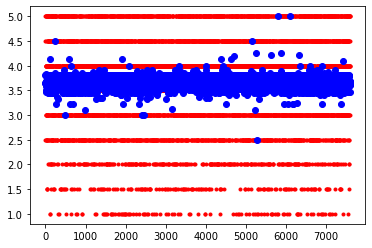

In [25]:
city_venue = list(range(0,len(xtest)))
plt.plot(city_venue, ytest, 'r.' ,label='Actual')
plt.plot(city_venue, city_test_pred, 'bo' ,label='Pred')

(array([ 102.,  146.,  284.,  620.,    0., 1050., 1697., 1667., 1089.,
         933.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

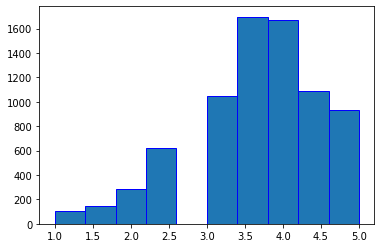

In [26]:
plt.hist(ytest, bins=10, range=(1,5), edgecolor='b')

In [27]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self

    def transform(self, X):
        tx_undata = [] #not formatted so UNformatted DATA
        for i in self.col_names:
            tx_undata.append([row[i] for row in X])

        len_col = len(tx_undata)

        tx_data = []
        for i in tx_undata[0]:
            tx_data.append([i])
        for i in range(1, len(self.col_names)):
            for j in range(len(tx_data)):
                tx_data[j].append(tx_undata[i][j])

        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return tx_data


In [28]:
col_in = ['latitude', 'longitude']
cst = ColumnSelectTransformer(col_in)
data_subset = data[0:5]
cst2 = cst.fit_transform(data_subset)
cst3 = [[i['latitude'], i['longitude']] for i in data_subset]
print(cst2 == cst3)

True


In [29]:
col_in = ['latitude', 'longitude']

pipe = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                 ('knear', KNeighborsRegressor(n_jobs=-1))])

#pipe.fit(xtrain, ytrain)

In [57]:
kparams = { 'knear__n_neighbors': [90, 100, 110, 120, 200],
            'knear__weights': ['uniform', 'distance']}

cn = GridSearchCV(pipe, kparams, cv=5, scoring='neg_mean_squared_error')
cn.fit(xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntx',
                                        ColumnSelectTransformer(col_names=['latitude',
                                                                           'longitude'])),
                                       ('knear',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=100,
                                                            p=2,
                                                            weights='uniform'))],
               

In [58]:
cn.best_params_

{'knear__n_neighbors': 100, 'knear__weights': 'uniform'}

In [61]:
pipe = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                 ('knear', KNeighborsRegressor(n_neighbors=100, n_jobs=-1))])
pipe.fit(xtrain, ytrain)

Pipeline(memory=None,
         steps=[('columntx',
                 ColumnSelectTransformer(col_names=['latitude', 'longitude'])),
                ('knear',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=-1, n_neighbors=100, p=2,
                                     weights='uniform'))],
         verbose=False)

In [62]:
print(pred_score(pipe,xtest, ytest)[1])

0.7994039536109647


## Category Model

In [64]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ct_dt = []
        # the extra loop is because this is a list nested in a list nested in a list
        for i in X:
            for j in i:
                ct_dt.append({})
                for k in j:
                    ct_dt[-1][k] = 1

        return ct_dt

In [ ]:
col_in = ['categories']
cst = ColumnSelectTransformer(col_in).fit_transform(data_subset)
for i in cst:
    print(i)
print('\n')

cst2 = DictEncoder().fit_transform(cst)
for i in cst2:
    print(i)


In [75]:
col_in = ['categories']
pipe2 = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                  ('dict_enc', DictEncoder()),
                  ('dict_vec', DictVectorizer()),
                  ('ridge', Ridge())])

kparams = { 'ridge__alpha': [3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 10.0]}

catn = GridSearchCV(pipe2, kparams, cv=5, scoring='neg_mean_squared_error')
catn.fit(xtrain, ytrain)
catn.best_params_

{'ridge__alpha': 7.0}

In [77]:
col_in = ['categories']
pipe2 = Pipeline([('column tx', ColumnSelectTransformer(col_in)),
                  ('dict fixer', DictEncoder()),
                  ('dict vector', DictVectorizer()),
                  ('ridge model', Ridge(alpha=7.0))])

pipe2.fit(xtrain, ytrain)

Pipeline(memory=None,
         steps=[('column tx',
                 ColumnSelectTransformer(col_names=['categories'])),
                ('dict fixer', DictEncoder()),
                ('dict vector',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=True)),
                ('ridge model',
                 Ridge(alpha=7.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [78]:
print(pred_score(pipe2, xtest, ytest)[1])

0.6695429554892015


## Attribute Model

In [80]:
class DictAttEncoder(base.BaseEstimator, base.TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #self.at_lt = X   # attribute list
        at_dt = []  # attribute flat dictionary
        for i in X:
            for j in i:
                at_dt.append({})
                for k, l in j.items():
                    if not type(l) is dict:
                        if l == False:
                            at_dt[-1][k] = 0
                        elif l == True:
                            at_dt[-1][k] = 1
                        else:
                            at_dt[-1]['{}_{}'.format(k, l)] = 1
                    if type(l) is dict:
                        for m, n in l.items():
                            if n == False:
                                at_dt[-1]['{}_{}'.format(k, m)] = 0
                            elif n == True:
                                at_dt[-1]['{}_{}'.format(k, m)] = 1

        return at_dt

In [ ]:
col_in = ['attributes']
cst = ColumnSelectTransformer(col_in).fit_transform(data_subset)
for i in cst:
    print(i)
print('\n')

cst2 = DictAttEncoder().fit_transform(cst)
for i in cst2:
    print(i)


In [85]:
col_in = ['attributes']
pipe3 = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                  ('dict_fix', DictAttEncoder()),
                  ('dict_vec', DictVectorizer()),
                 ('forest', RandomForestRegressor(n_jobs=-1))])

kparams = { 'forest__n_estimators': [200, 300, 400],
            'forest__max_depth': [10, 25, 40],
            'forest__min_samples_split': [2, 10, 25, 50]}

fn = GridSearchCV(pipe3, kparams, cv=5, scoring='neg_mean_squared_error')
fn.fit(xtrain, ytrain)
fn.best_params_



{'forest__max_depth': 25,
 'forest__min_samples_split': 10,
 'forest__n_estimators': 400}

In [93]:
col_in = ['attributes']
pipe3 = Pipeline([('column tx', ColumnSelectTransformer(col_in)),
                  ('dict fixer', DictAttEncoder()),
                  ('dict vector', DictVectorizer()),
                 ('forest model', RandomForestRegressor(n_jobs=-1, max_depth=40,
                                                        n_estimators=300,
                                                        min_samples_split=50))])

pipe3.fit(xtrain, ytrain)

print(pred_score(pipe3, xtest, ytest)[1])

0.7367189393136958


## Residual Estimator

In [101]:
class DataAndResidualRegressor(base.BaseEstimator, base.TransformerMixin):

    def fit(self, X, y):
        self.data = X
        self.y_act = y

        self.data_model1 = RandomForestRegressor(n_jobs=-1, max_depth=40,
                                                        n_estimators=300,
                                                        min_samples_split=50)
        #self.data_model2 = Ridge(alpha=3.0)
        self.data_model2 = RandomForestRegressor(n_jobs=-1, max_depth=40,
                                                        n_estimators=300,
                                                        min_samples_split=50)

        self.data_model1.fit(self.data, self.y_act)
        self.y_est = self.data_model1.predict(self.data)
        self.y_res = self.y_act - self.y_est

        self.data_model2.fit(self.data, self.y_res)

        return self

    def predict(self, X):
        y_predict = self.data_model1.predict(X) + self.data_model2.predict(X)

        return y_predict


In [102]:
col_in = ['attributes']
pipe4 = Pipeline([('column tx', ColumnSelectTransformer(col_in)),
                  ('dict fixer', DictAttEncoder()),
                  ('dict vector', DictVectorizer()),
                  ('data res model', DataAndResidualRegressor())])

pipe4.fit(xtrain, ytrain)
print(pred_score(pipe4, xtest, ytest)[1])

0.735253674452472


## Custom Estimator

In [103]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, estimator):
        self.estimator = estimator
        #return self

    # What needs to be done here?

    def fit(self, X, y):
        self.estimator.fit(X,y)
        return self

    # Fit the stored estimator.
    # Question: what should be returned?

    def transform(self, X):
        self.y_est = self.estimator.predict(X)
        self.y_out = [[i] for i in self.y_est]

        return self.y_out

In [ ]:

# Use predict on the stored estimator as a "transformation".
# Be sure to return a 2-D array.

############################################################

data = dill.load(open('data.pkd', 'rb'))
star_ratings = [row['stars'] for row in data]

city_est = CityEstimator()
city_trans = EstimatorTransformer(city_est)

city_trans.fit(data, star_ratings)
assert ([r[0] for r in city_trans.transform(data[:5])]
        == city_est.predict(data[:5]))



union = FeatureUnion([('city est', city_trans),
                      ('lat long', latlong_trans),
                      ('cat mod', cat_trans),
                      ('att mod', att_trans)])



In [104]:
from sklearn.pipeline import FeatureUnion


city_trans = EstimatorTransformer(city_est)
latlong_trans = EstimatorTransformer(pipe)
cat_trans = EstimatorTransformer(pipe2)
att_trans = EstimatorTransformer(pipe4)


union = FeatureUnion([('city est', city_trans),
                      ('lat long', latlong_trans),
                      ('cat mod', cat_trans),
                      ('att mod', att_trans)])

In [105]:


lr_model = LinearRegression()
#lr_model = RandomForestRegressor(n_estimators=20)

pipe5 = Pipeline([('columns all', union),
                 ('lin model', lr_model)])

pipe5.fit(xtrain, ytrain)

Pipeline(memory=None,
         steps=[('columns all',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('city est',
                                                 EstimatorTransformer(estimator=CityEstimator())),
                                                ('lat long',
                                                 EstimatorTransformer(estimator=Pipeline(memory=None,
                                                                                         steps=[('columntx',
                                                                                                 ColumnSelectTransformer(col_names=['latitude',
                                                                                                                                    'longitude'])),
                                                                                                ('knear',
                                                                         

In [107]:
pipe5_y, p5_score = pred_score(pipe5, xtest, ytest)
print(p5_score)

0.657529201564279


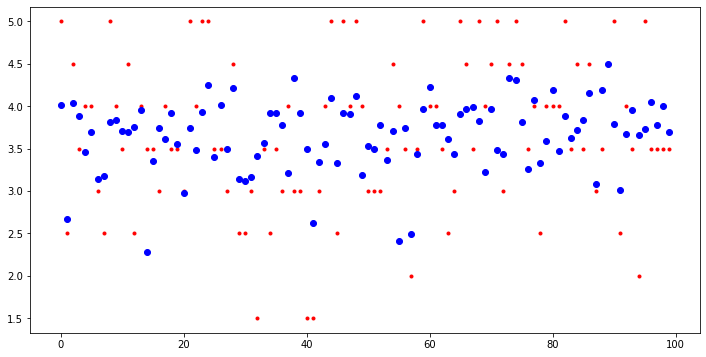

In [114]:
city_venue = list(range(0,len(xtest)))
plt.figure(figsize=(12,6))
plt.plot(city_venue[0:100], ytest[0:100], 'r.' ,label='Actual')
plt.plot(city_venue[0:100], pipe5_y[0:100], 'bo' ,label='Pred')

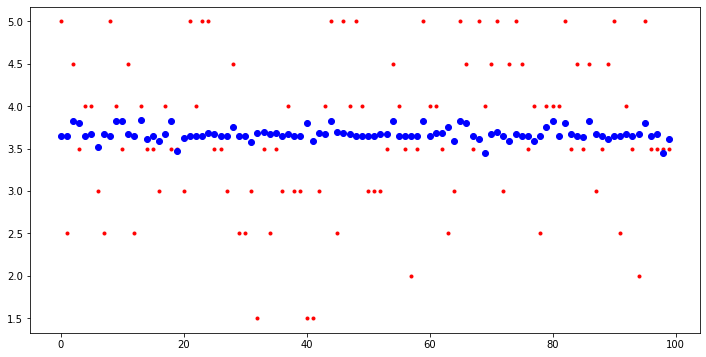

In [115]:
city_venue = list(range(0,len(xtest)))
plt.figure(figsize=(12,6))
plt.plot(city_venue[0:100], ytest[0:100], 'r.' ,label='Actual')
plt.plot(city_venue[0:100], city_test_pred[0:100], 'bo' ,label='Pred')